In [1]:

import matplotlib.pyplot as plt 
from glob import glob
import numpy as np

import tensorflow as tf
import tensorflow.keras.utils as np_utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
#from keras.utils.training_utils import multi_gpu_model

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os

import pickle
from joblib import dump, load
import pandas as pd


2023-08-08 04:42:46.577713: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 04:42:46.638173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GPU 메모리 자동 증가 설정

In [2]:
# GPU 메모리 자동 증가 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# TensorFlow GPU 메모리 자동 증가 설정   
config = tf.compat.v1.ConfigProto()   
config.gpu_options.allow_growth = True   
session = tf.compat.v1.Session(config=config)   
tf.compat.v1.keras.backend.set_session(session)   

In [3]:
base='/tf/'
Grids=1000
data = np.load(base+str(Grids)+'data.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [4]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')
X_val = X_val.reshape((X_val.shape[0], num_pixels)).astype('float32')

maxvalue=X_train[X_train>0].max()

X_train = X_train / maxvalue
X_train[np.isnan(X_train)==True]=0
X_train[np.isinf(X_train)==True]=0

X_test = X_test / maxvalue
X_test[np.isnan(X_test)==True]=0
X_test[np.isinf(X_test)==True]=0

X_val = X_val / maxvalue
X_val[np.isnan(X_val)==True]=0
X_val[np.isinf(X_val)==True]=0

## One-hot encode outputs

In [5]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

## Model builiding

In [6]:
strategy = tf.distribute.MirroredStrategy()
nodes,Droprate=512,0.2
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(nodes, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(Droprate))
    
    model.add(Dense(nodes, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(Droprate))
    
    model.add(Dense(nodes, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(Droprate))
    
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
     #tfa.losses.SigmoidFocalCrossEntropy()
    return model
# build the model
with strategy.scope():
    model=baseline_model()
    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-08-08 04:42:56.025706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46686 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6
2023-08-08 04:42:56.026268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46686 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b1:00.0, compute capability: 8.6


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               512000512 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1

## Model training

In [8]:

# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Saving the model
save_dir = "/tf/Results/models/%i/Log/MLP/"%Grids
model_name = '%i_HL3_%i'%(Grids,nodes)#_Drop_0.2
model_path = os.path.join(save_dir, model_name+'.h5')
model.save(model_path)
print('\n Saved trained model at %s ' % model_path)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


# Saving history of the model
dump(history.history, '/tf/Results/histories/%i/Log/MLP/'%Grids+model_name+'.joblib')

Epoch 1/20
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/rep

2023-08-08 04:43:01.561224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-08 04:43:02.868441: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x278dd970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-08 04:43:02.868531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-08-08 04:43:02.868551: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-08-08 04:43:02.877128: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-08 04:43:03.089748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-08 04:43:03.255029: I

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
8/8 - 9s - loss: 244.9746 - accuracy: 0.5119 - val_loss: 231.6787 - val_accuracy: 0.6719 - 9s/epoch - 1s/step
Epoch 2/20
8/8 - 2s - loss: 217.1263 - accuracy: 0.5437 - val_loss: 107.3687 - val_accuracy: 0.6719 - 2s/epoch - 266ms/step
Epoch 3/20
8/8 - 2s - loss: 131.0623 - accuracy: 0.5198 - val_loss: 9.3850 - val_accuracy: 0.7031 - 2s/epoch - 265ms/step
Epoch 4/20
8/8 - 2s - loss: 58.5857 - accuracy: 0.5952 - val_loss: 39.1001 - val_accuracy: 0.2656 - 2s/epoch - 270ms/step
Epoch 5/20
8/8 - 2s - loss: 27.4889 - accuracy: 0.5397 - val_loss: 14.3531 - val_accuracy: 0.6719 - 2s/epoch - 264ms/step
Epoch 6/20
8/8 - 2s - loss: 19.6208 - accuracy: 0.5397 - val_loss: 13.0682 - val_accuracy: 0.2656 - 2s/epoch - 296ms/ste

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



 Saved trained model at /tf/Results/models/1000/Log/MLP/1000_HL3_512.h5 
Baseline Error: 32.50%


['/tf/Results/histories/1000/Log/MLP/1000_HL3_512.joblib']

## Model 별 Accuracy, loss 변화도

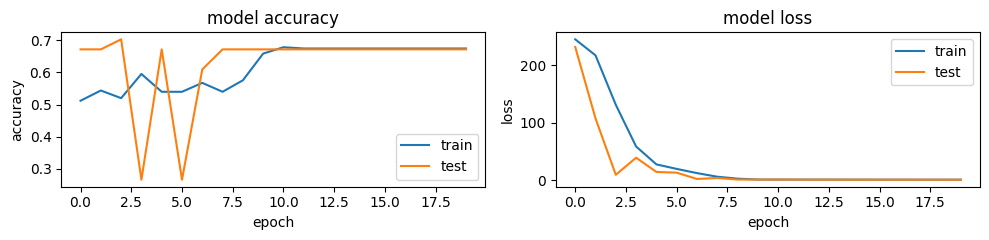

In [9]:
# plotting the metrics
fig = plt.figure(figsize=(10,2.5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()

## Drawing Confusion Matrix

In [10]:
y_pred=model.predict(X_test)
confM=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
class_totals = np.sum(confM, axis=1)
cm_norm = confM / class_totals[:, np.newaxis]
np.savez('/tf/Results/confusion/'+str(Grids)+'/Log/MLP/'+model_name+'.npz', confusion=confM)

3/3 [==============================] - 0s 17ms/step


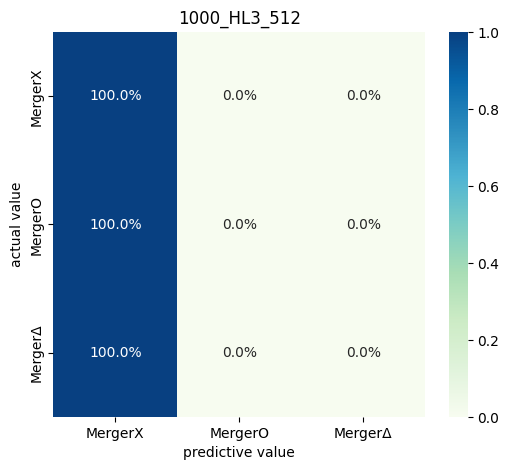

In [11]:
labels=['MergerX','MergerO','MergerΔ']
#print(data)
# Drawing confusion matrix with seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm,annot=True,fmt=".1%",cmap='GnBu',xticklabels=labels, yticklabels=labels)
plt.xlabel('predictive value')
plt.ylabel('actual value')

plt.title(model_name)
plt.show() 

In [12]:
report=classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),output_dict=True)

df=pd.DataFrame(report).transpose()
df.to_hdf('/tf/Results/confusion/'+str(Grids)+'/Log/MLP/'+model_name+'.h5',key='Galaxy',mode='w')   
df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.675000,1.000000,0.805970,54.000
1,0.000000,0.000000,0.000000,21.000
2,0.000000,0.000000,0.000000,5.000
accuracy,0.675000,0.675000,0.675000,0.675
macro avg,0.225000,0.333333,0.268657,80.000
weighted avg,0.455625,0.675000,0.544030,80.000
